# SAN - Praktische Arbeit (Marvel Universe Social Network)

## Netzwerkanalyse

In [23]:
import os
import sys
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import scipy as sp
from scipy.spatial.distance import jaccard
from itertools import combinations
from helper import *

## Daten einlesen

In [24]:
nodes = pd.read_csv('Daten/nodes.csv')
edges = pd.read_csv('Daten/edges.csv')
hero_network = pd.read_csv('Daten/hero-network.csv')

print(nodes.head())
print(edges.head())
print(hero_network.head())

                   node   type
0               2001 10  comic
1                2001 8  comic
2                2001 9  comic
3  24-HOUR MAN/EMMANUEL   hero
4  3-D MAN/CHARLES CHAN   hero
                   hero   comic
0  24-HOUR MAN/EMMANUEL  AA2 35
1  3-D MAN/CHARLES CHAN   AVF 4
2  3-D MAN/CHARLES CHAN   AVF 5
3  3-D MAN/CHARLES CHAN   COC 1
4  3-D MAN/CHARLES CHAN  H2 251
                  hero1                 hero2
0         LITTLE, ABNER        PRINCESS ZANDA
1         LITTLE, ABNER  BLACK PANTHER/T'CHAL
2  BLACK PANTHER/T'CHAL        PRINCESS ZANDA
3         LITTLE, ABNER        PRINCESS ZANDA
4         LITTLE, ABNER  BLACK PANTHER/T'CHAL


# ANALYSE des hero_network DATENSATZES

Wir überprüfen die Charaktere mit den meisten Verbindungen zu anderen Charakteren im Netzwerk. Dann erstellen wir die Ähnlichkeitsanalyse auf einer beschränkten Gruppe (N=100) und überprüefen, ob die Ergebnis unseren Berechnungen gleich kommen.

In [45]:
# Identifying the most frequently occurring characters
hero_counts = pd.concat([hero_network['hero1'], hero_network['hero2']]).value_counts()

# Selecting the top N most frequent characters for analysis
N = 100 
top_heroes = hero_counts.head(N).index

# Filtering the hero_network_df to include only relationships involving the top characters
filtered_hero_network_df = hero_network[(hero_network['hero1'].isin(top_heroes)) & 
                                           (hero_network['hero2'].isin(top_heroes))]

# Creating a new matrix for the filtered data
filtered_hero_matrix = pd.DataFrame(0, index=top_heroes, columns=top_heroes, dtype=int)

# Filling the matrix based on the relationships in filtered_hero_network_df
for index, row in filtered_hero_network_df.iterrows():
    filtered_hero_matrix.at[row['hero1'], row['hero2']] = 1
    filtered_hero_matrix.at[row['hero2'], row['hero1']] = 1  # Assuming undirected relationships

# Calculating the Jaccard similarity for the filtered matrix
filtered_hero_matrix_np = filtered_hero_matrix.to_numpy()
filtered_jaccard_distances = pairwise_distances(filtered_hero_matrix_np, metric=lambda u, v: jaccard(u, v, w=None), n_jobs=-1)
filtered_jaccard_similarities = 1 - filtered_jaccard_distances

# Creating a DataFrame for the filtered similarities
filtered_jaccard_sim_df = pd.DataFrame(filtered_jaccard_similarities, index=top_heroes, columns=top_heroes)

# Display a portion of the similarity matrix for the top heroes
print("Jaccard Similarity Matrix für die top heroes:")
filtered_jaccard_sim_df.iloc[:5, :5]  # Displaying a small section for readability


Jaccard Similarity Matrix für die top heroes:


CAPTAIN AMERICA  SPIDER-MAN/PETER PAR  \
CAPTAIN AMERICA                  1.00              0.960000   
SPIDER-MAN/PETER PAR             0.96              1.000000   
IRON MAN/TONY STARK              0.97              0.949495   
THOR/DR. DONALD BLAK             0.95              0.948980   
THING/BENJAMIN J. GR             0.96              0.959184   

                      IRON MAN/TONY STARK   THOR/DR. DONALD BLAK  \
CAPTAIN AMERICA                   0.970000              0.950000   
SPIDER-MAN/PETER PAR              0.949495              0.948980   
IRON MAN/TONY STARK               1.000000              0.959184   
THOR/DR. DONALD BLAK              0.959184              1.000000   
THING/BENJAMIN J. GR              0.949495              0.929293   

                      THING/BENJAMIN J. GR  
CAPTAIN AMERICA                   0.960000  
SPIDER-MAN/PETER PAR              0.959184  
IRON MAN/TONY STARK               0.949495  
THOR/DR. DONALD BLAK              0.929293  
THING/BENJAMIN J. GR              1.000000

# Verbindung zwischen captain america,ironman und spiderman

Wir haben herausgefunden, dass Captain America, Ironman und Spider-Man im `hero-network.csv` die meisten verbindungen haben. Wir wollen nun herausfinden, wie die  anderen Helden mit unseren "Haupt-Helden" verbunden sind und welche Helden nur auf einen, mit zwei oder drei "Haupt-Helden" verbunden sind.

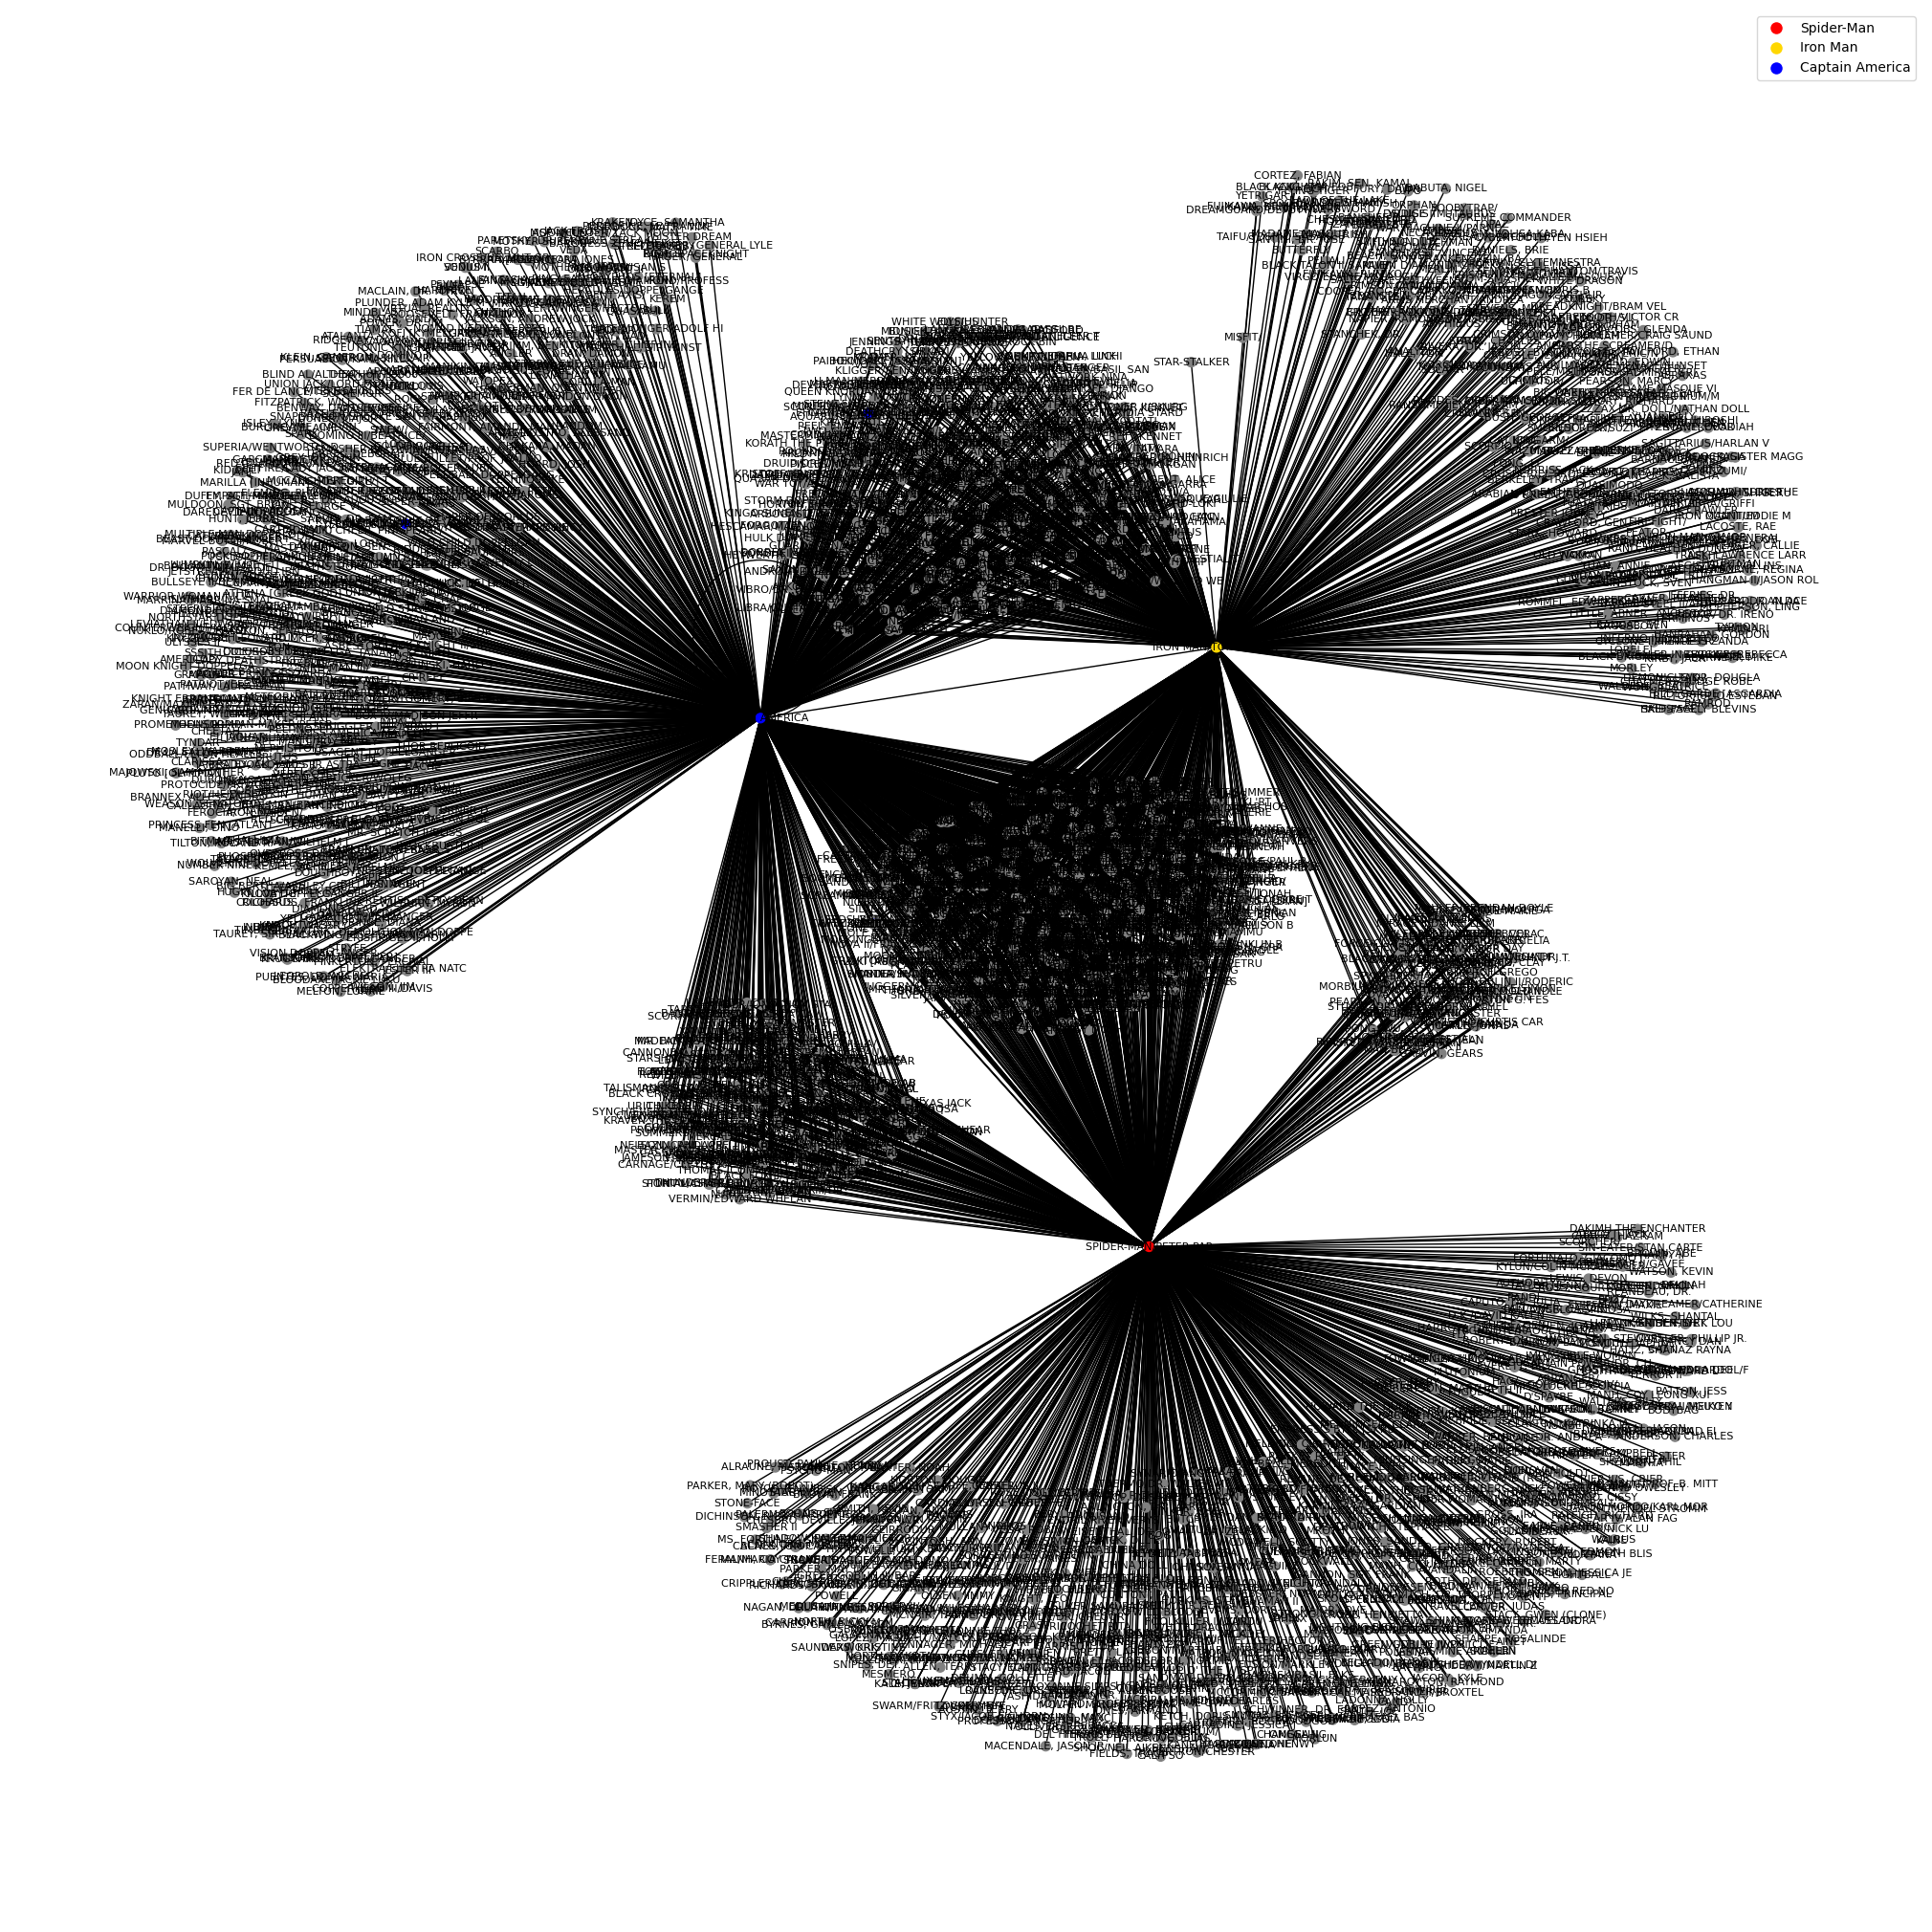

In [26]:
# connection between captain america,ironman and spiderman
captAmerica = Subset = hero_network[hero_network['hero1'] == 'CAPTAIN AMERICA']
ironMan = hero_network[hero_network['hero1'].str.contains('IRON MAN/TONY STARK')]
spiderMan = hero_network[hero_network['hero1'].str.contains('SPIDER-MAN/PETER PAR')]
Subset = pd.concat([captAmerica, ironMan, spiderMan], axis=0)

G = nx.from_pandas_edgelist(Subset, 'hero1', 'hero2')

node_colors = []

for node in G.nodes():
    if 'SPIDER-MAN/PETER PAR' in node:
        node_colors.append('red')  # Spider-Man in Rot
    elif 'IRON MAN/TONY STARK' in node:
        node_colors.append('gold')  # Iron Man in Gold
    elif 'CAPTAIN AMERICA' in node:
        node_colors.append('blue')  # Captain America in Blau
    else:
        node_colors.append('grey')  # Alle anderen Knoten in Grau
        
plt.figure(figsize=(20, 20))
nx.draw(G, node_color=node_colors, with_labels=True, node_size=50, font_size=8)

# Create a legend
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Spider-Man',
                          markersize=10, markerfacecolor='red')
gold_patch = plt.Line2D([0], [0], marker='o', color='w', label='Iron Man',
                          markersize=10, markerfacecolor='gold')
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Captain America',
                          markersize=10, markerfacecolor='blue')
plt.legend(handles=[red_patch, gold_patch, blue_patch])

plt.show()

Wir sehen, dass Captain America und Spider Man sehr viele Einzelne verbindungen zu Helden haben. Es gibt auch sehr viele Helden, welche eine Verbingung zu allen 3 "Haupt-Helden" haben. Zudem ist gut zu erkennen, dass es es sehr wenige Helden gibt, die zu Iron Man und Spider Man verbunden sind. Um das angewendete Prizip ein bisschen besser veranzuschaulichen, visualisieren wir im folgenden Plot noch eine vereinfachte Version des Netzwerkes mit 25 samples pro "Haupt-Held".

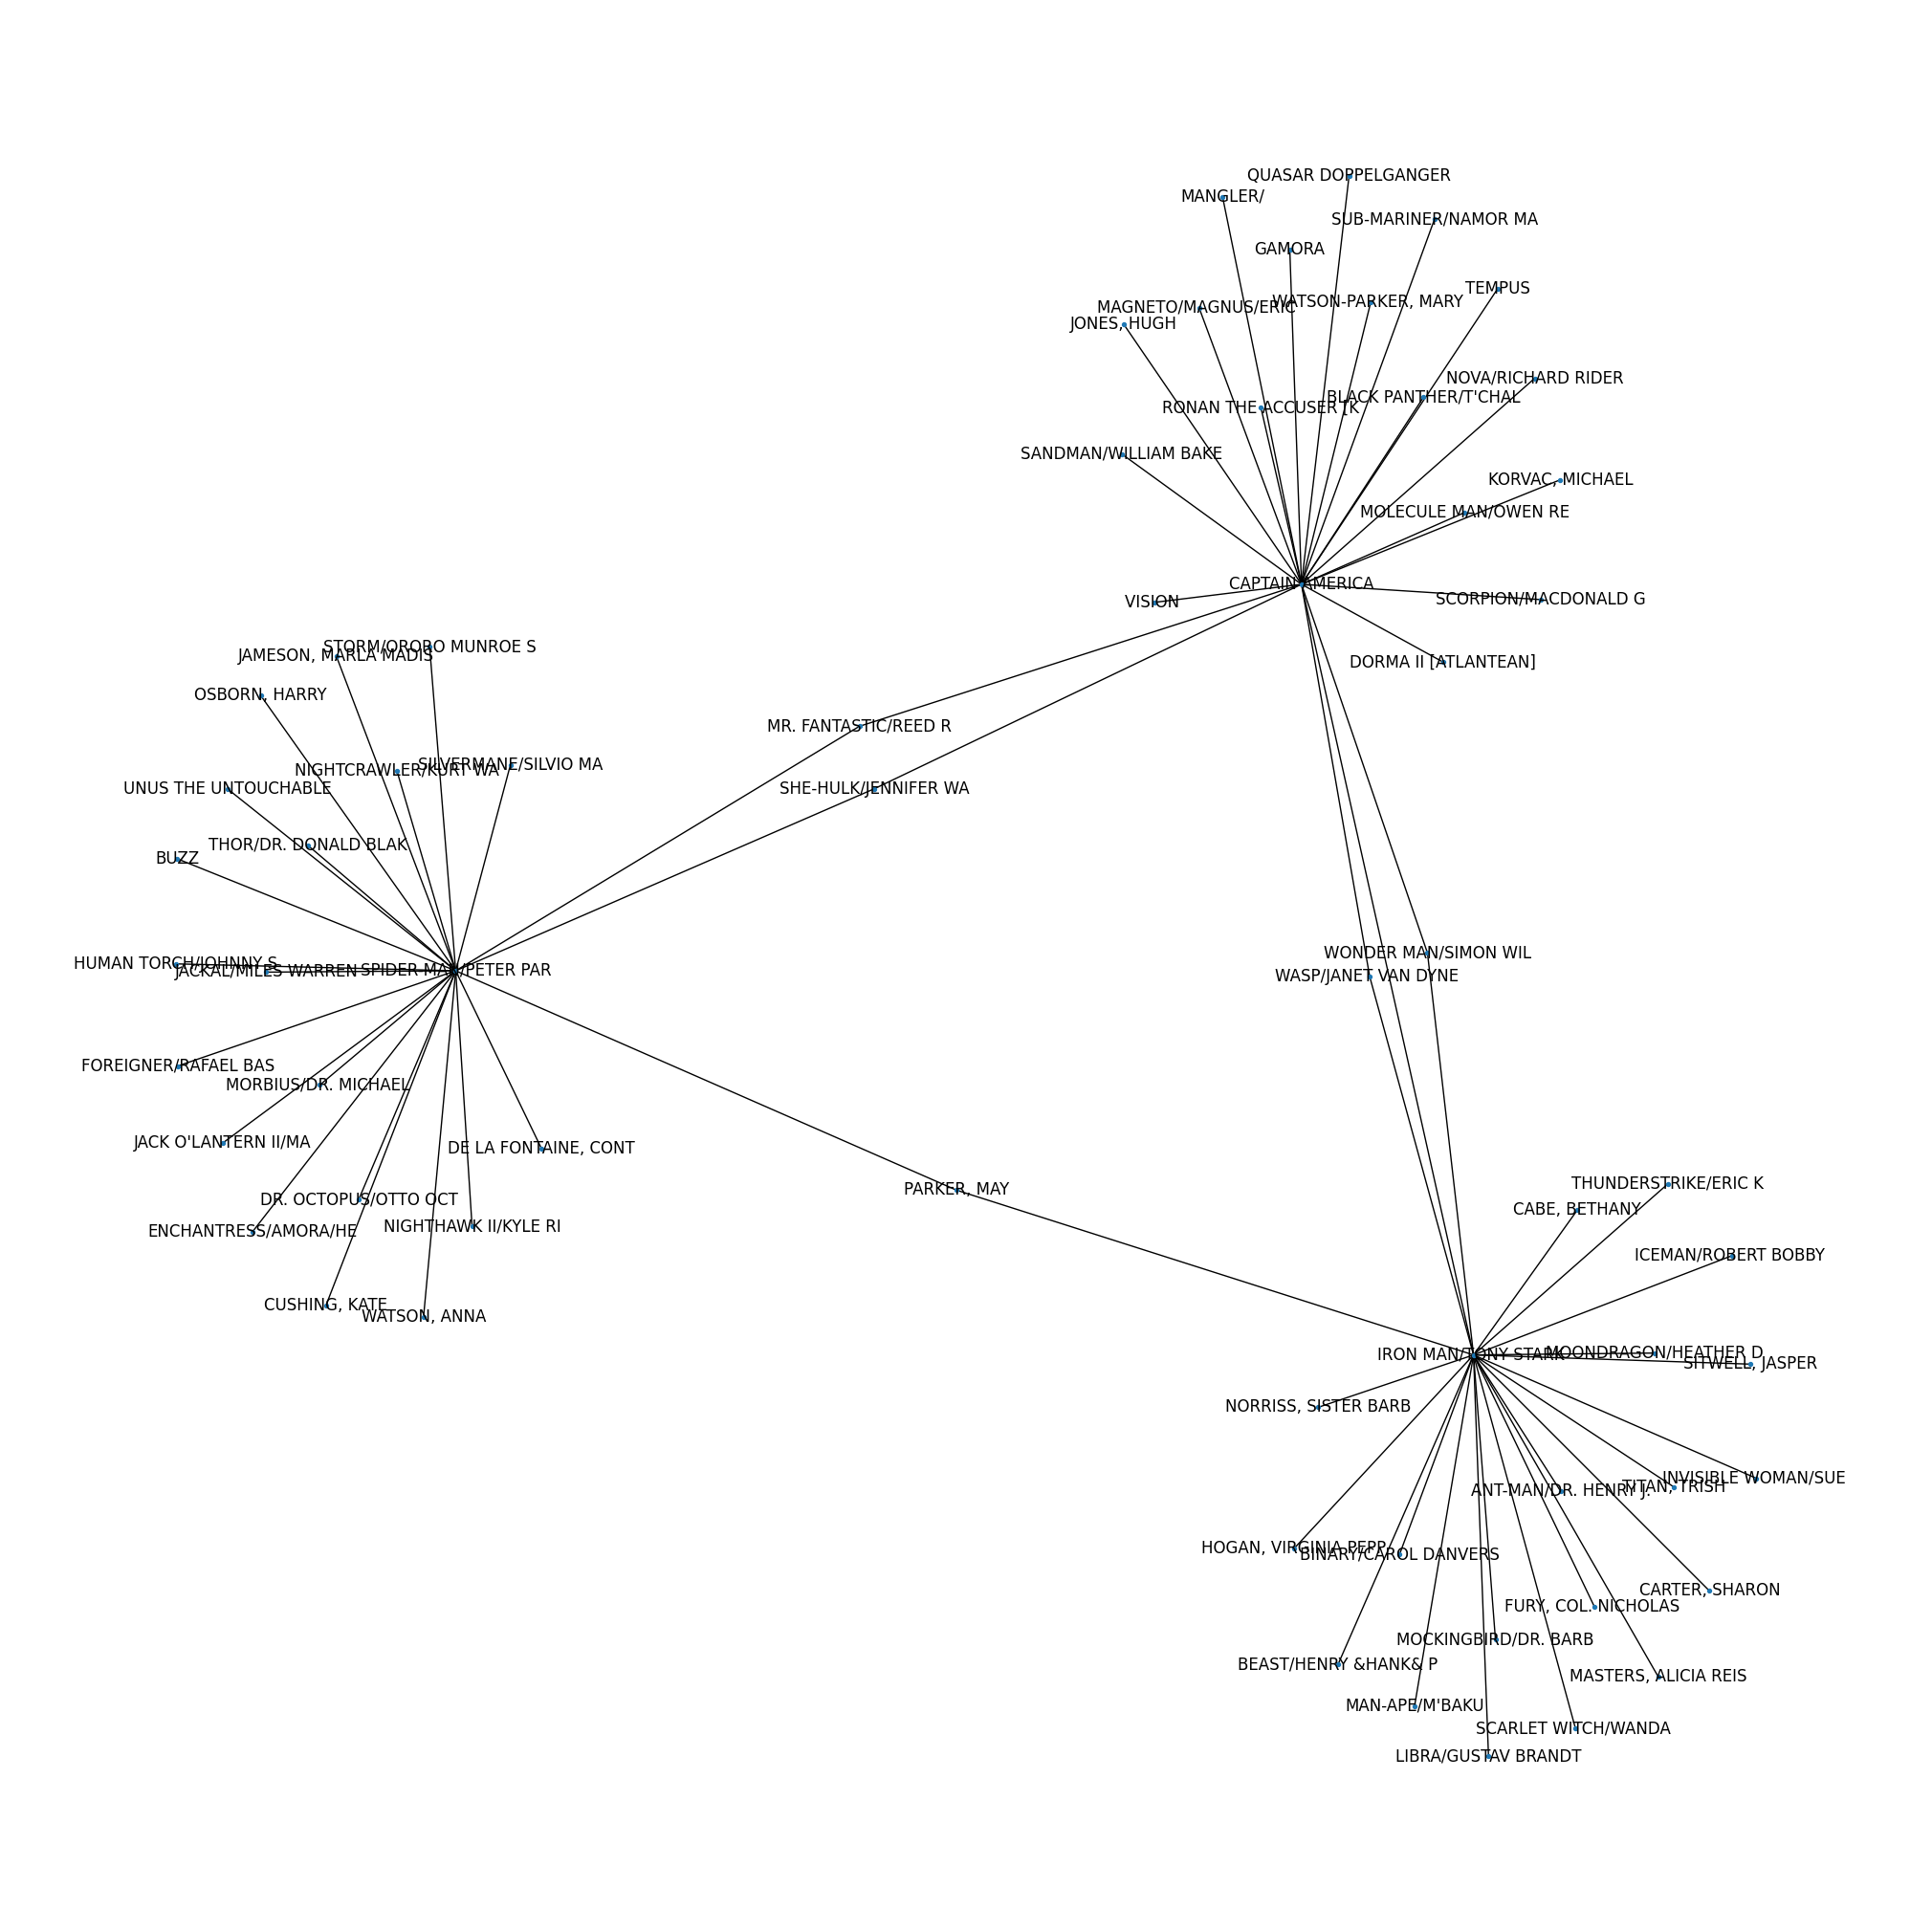

In [27]:
# connection between captain america,ironman and spiderman
captAmerica_sample = Subset_sample = hero_network[hero_network['hero1'] == 'CAPTAIN AMERICA'].sample(25)
ironMan_sample = hero_network[hero_network['hero1'].str.contains('IRON MAN/TONY STARK')].sample(25)
spiderMan_sample = hero_network[hero_network['hero1'].str.contains('SPIDER-MAN/PETER PAR')].sample(25)
Subset_sample = pd.concat([captAmerica_sample, ironMan_sample, spiderMan_sample], axis=0)

G = nx.from_pandas_edgelist(Subset_sample, 'hero1', 'hero2')

plt.figure(figsize=(20, 20))
nx.draw(G, with_labels=True, node_size=8)
plt.show()

Die vereinfachte Ansicht, gibt uns eine gute Übersicht. Je nach seed sehen wir, wie auch schon in der gesamt Ansicht, dass Captain America mehrmals vorkommen muss. Uns interessiert aber vorerst die genaue Anzahl der Verbindungen. Dazu erstellen wir eine Tabelle mit den Anzahl Verbindungen zu den "Haupt-Helden". Die "mehrfachen Captain America's" analysieren wir danach.

In [28]:
# To create the table as requested, we need to count the connections based on the criteria given.
# We will assume that the hero_network dataframe has already been loaded as per previous code snippets.

# Counting connections for each main hero
capt_america_count = captAmerica['hero2'].nunique()
iron_man_count = ironMan['hero2'].nunique()
spiderman_count = spiderMan['hero2'].nunique()

# Counting mutual connections
capt_america_iron_man = hero_network[(hero_network['hero1'] == 'CAPTAIN AMERICA') & 
                                      hero_network['hero2'].str.contains('IRON MAN/TONY STARK')].shape[0]
capt_america_spiderman = hero_network[(hero_network['hero1'] == 'CAPTAIN AMERICA') & 
                                       hero_network['hero2'].str.contains('SPIDER-MAN/PETER PAR')].shape[0]
iron_man_spiderman = hero_network[(hero_network['hero1'].str.contains('IRON MAN/TONY STARK')) & 
                                  hero_network['hero2'].str.contains('SPIDER-MAN/PETER PAR')].shape[0]

# Counting connections between all three
all_three_connections = hero_network[(hero_network['hero1'].str.contains('CAPTAIN AMERICA') & 
                                      hero_network['hero2'].str.contains('IRON MAN/TONY STARK')) |
                                     (hero_network['hero1'].str.contains('IRON MAN/TONY STARK') & 
                                      hero_network['hero2'].str.contains('SPIDER-MAN/PETER PAR')) |
                                     (hero_network['hero1'].str.contains('CAPTAIN AMERICA') & 
                                      hero_network['hero2'].str.contains('SPIDER-MAN/PETER PAR'))].shape[0]

# Creating the table
table_data = {
    'Connection': ['Captain America', 'Captain America - Spiderman', 'Captain America - Iron Man',
                   'Iron Man', 'Iron Man - Spiderman', 'Spiderman', 
                   'Captain America - Iron Man - Spiderman'],
    'Number of Connections': [capt_america_count, capt_america_spiderman, capt_america_iron_man,
                              iron_man_count, iron_man_spiderman, spiderman_count,
                              all_three_connections]
}

connection_table = pd.DataFrame(table_data)

connection_table.sort_values(by='Number of Connections', ascending=False)



Connection  Number of Connections
0                         Captain America                   1426
5                               Spiderman                   1286
3                                Iron Man                   1132
6  Captain America - Iron Man - Spiderman                    353
2              Captain America - Iron Man                    220
1             Captain America - Spiderman                     79
4                    Iron Man - Spiderman                     54

# Analyse der "Selbsverbindungen" von den Haupt-Helden

In [32]:
#check if hero has a self connection
selfconnection_capt = hero_network[(hero_network['hero1'].str.contains('CAPTAIN AMERICA') & hero_network['hero2'].str.contains('CAPTAIN AMERICA'))].shape[0]

selfconnection_ironman = hero_network[(hero_network['hero1'].str.contains('IRON MAN/TONY STARK') & hero_network['hero2'].str.contains('IRON MAN/TONY STARK'))].shape[0]

selfconnection_spiderman = hero_network[(hero_network['hero1'].str.contains('SPIDER-MAN/PETER PAR') & hero_network['hero2'].str.contains('SPIDER-MAN/PETER PAR'))].shape[0]

print(f"Anzahl Verbindungen von Captain America zu Captain America: {selfconnection_capt}")
print(f"Anzahl Verbindungen von IRON MAN/TONY STARK zu IRON MAN/TONY STARK: {selfconnection_ironman}")
print(f"Anzahl Verbindungen von SPIDER-MAN/PETER PAR zu SPIDER-MAN/PETER PAR: {selfconnection_spiderman}")

Anzahl Verbindungen von Captain America zu Captain America: 143
Anzahl Verbindungen von IRON MAN/TONY STARK zu IRON MAN/TONY STARK: 0
Anzahl Verbindungen von SPIDER-MAN/PETER PAR zu SPIDER-MAN/PETER PAR: 0


Captain America hat 143 mal eine Verbindung auf sich selbst. Woran liegt das? 

In [ ]:
print(selfconnection_capt)
cap_edge = edges[edges['hero'] == 'CAPTAIN AMERICA']
print(len(cap_edge))

In [53]:
# Finden Sie die ID von Captain America in den Nodes
captain_america_id = nodes[nodes['type'] == 'hero' & nodes['node'] == 'Captain America']['id'].iloc[0]

# Filtern Sie die Kanten, um nur diejenigen mit Captain America zu erhalten
captain_edges = edges[edges['hero'] == captain_america_id]

# Zählen Sie, wie oft Captain America in jedem Comic erscheint
comic_counts = captain_edges['comic'].value_counts()

# Filtern Sie Comics heraus, in denen Captain America mehr als einmal erscheint
comics_with_multiple_captain_america = comic_counts[comic_counts > 1]

print(comics_with_multiple_captain_america)


TypeError: Cannot perform 'rand_' with a dtyped [object] array and scalar of type [bool]

# Gemeinsame Comics von captain america,ironman und spiderman 

In [39]:
# identify names of Captain America, Iron Man und Spider-Man
captain_america_names = [name for name in nodes[nodes['type'] == 'hero']['node'] if 'CAPTAIN AMERICA' in name]
iron_man_names = [name for name in nodes[nodes['type'] == 'hero']['node'] if 'IRON MAN' in name]
spider_man_names = [name for name in nodes[nodes['type'] == 'hero']['node'] if 'SPIDER-MAN' in name]

# find comics with these names
captain_america_comics = edges[edges['hero'].isin(captain_america_names)]['comic'].unique()
iron_man_comics = edges[edges['hero'].isin(iron_man_names)]['comic'].unique()
spider_man_comics = edges[edges['hero'].isin(spider_man_names)]['comic'].unique()

# find common comics
common_comics = set(captain_america_comics) & set(iron_man_comics) & set(spider_man_comics)

# Anzahl und Liste der gemeinsamen Comics
print(f" shared comics: {len(common_comics)}| {common_comics}")

 shared comics: 3| {'ASM2 1', 'A 400', 'SMTU 4'}
1352


Comic Namen:
A 400   :  AVENGERS 400
SMTU 4  : Spider-Man Team-Up 4
ASM2 1  : Amazing Spider-Man 2 

In diesen Comics kommen alle 3 Helden vor.